<a href="https://colab.research.google.com/github/pienight/Machinelearning/blob/master/MLass2_Alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Preparation

**1.1 Import required packages**

In [1]:
import os
import tensorflow as tf
import zipfile
from tensorflow.keras import layers
from tensorflow.keras import Model
from sklearn.preprocessing import LabelBinarizer
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import LSTM, Input
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD
from keras.datasets import cifar10
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, RMSprop
from tqdm import tqdm
import numpy as np
import pandas as pd
import skimage
from skimage import io, transform
from IPython.display import Image, display
import shutil
from keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
import random
# packages for visualization
import ipywidgets as iw
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from skimage.transform import resize as imresize
from glob import glob

Using TensorFlow backend.


**1.2 Mount the Google Drive**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
cd /content/gdrive/My Drive/testx

/content/gdrive/My Drive/testx


In [0]:


#此代码将数据集文件分为训练集，交叉验证集，测试集
train_rate=0.7
val_rate=0.1
test_rate=0.2
rates=[train_rate,val_rate,test_rate]
base_dir='/content/gdrive/My Drive/17Flower'
jpg_list=os.listdir(base_dir)
#打乱图像数据集
random.shuffle(jpg_list)

labels=['Daffodil', 'Snowdrop', 'LilyValley', 'Bluebell', 'Crocus', 'Iris', 'Tigerlily', 'Tulip', 'Fritillary',
              'Sunflower', 'Daisy', 'ColtsFoot', 'Dandelion', 'Cowslip', 'Buttercup', 'Windflower', 'Pansy']
#按照比例，制作三个集合
def make_set(rates):
    len_ipg_list=len(jpg_list)
    train_index_start=0
    train_index_end=int(len_ipg_list*rates[0])
    val_index_end = int(len_ipg_list * rates[1])+train_index_end
    test_index_end=int(len_ipg_list * rates[2])+val_index_end
    #生成训练集
    for i in range(17):
        path='data_split/train/'+labels[i]
        if(not os.path.exists(path)):
            os.makedirs(path)
    for i in range(train_index_start,train_index_end):
        jpg_name=jpg_list[i]
        jpg_class=labels[int((int(jpg_name[6:10])-1)/80)]
        dst_path='data_split/train/'+jpg_class+'/'+jpg_name
        shutil.copyfile(os.path.join(base_dir,jpg_list[i]), dst_path)
    #生成交叉验证集
    for i in range(17):
        path='data_split/val/'+labels[i]
        if(not os.path.exists(path)):
            os.makedirs(path)
    for i in range(train_index_end,val_index_end):
        jpg_name=jpg_list[i]
        jpg_class=labels[int((int(jpg_name[6:10])-1)/80)]
        dst_path='data_split/val/'+jpg_class+'/'+jpg_name
        shutil.copyfile(os.path.join(base_dir,jpg_list[i]), dst_path)
    #生成测试集
        # 生成交叉验证集
        for i in range(17):
            path = 'data_split/test/' + labels[i]
            if (not os.path.exists(path)):
                os.makedirs(path)
        for i in range(val_index_end, test_index_end):
            jpg_name = jpg_list[i]
            jpg_class = labels[int((int(jpg_name[6:10]) - 1) / 80)]
            dst_path = 'data_split/test/' + jpg_class+'/'+jpg_name
            shutil.copyfile(os.path.join(base_dir, jpg_list[i]), dst_path)
make_set(rates)

# 2. Data Preparation

In [0]:
train_dir = '/content/gdrive/My Drive/testx/data_split/train'
test_dir = '/content/gdrive/My Drive/testx/data_split/test'
validation_dir = '/content/gdrive/My Drive/testx/data_split/val'

**2.3 Image Augmentation Setting**

In [0]:
train_gen_cnn = ImageDataGenerator(rescale=1./255, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')
test_gen_cnn = ImageDataGenerator(rescale=1./255)
validation_gen_cnn = ImageDataGenerator(rescale=1./255, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')

train_gen_alexnet = ImageDataGenerator(rescale=1./255, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')
test_gen_alexnet = ImageDataGenerator(rescale=1./255)
validation_gen_alexnet = ImageDataGenerator(rescale=1./255, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.1, horizontal_flip=True, fill_mode='nearest')

**2.4 Define the function to load image into array**

In [0]:
img_size = 50

def get_data(folder_path):
    imgs = []
    indices = []
    labels = []
    for idx, folder_name in enumerate(tqdm(os.listdir(folder_path))):
        if not folder_name.startswith('.'):
            labels.append(folder_name)
            for file_name in os.listdir(folder_path + '/' + folder_name):
                if not file_name.startswith('.'):
                    img_file = io.imread(folder_path + '/' + folder_name + '/' + file_name)
                    if img_file is not None:
                        img_file = transform.resize(img_file, (img_size, img_size))
                        imgs.append(np.asarray(img_file))
                        indices.append(idx)
    imgs = np.asarray(imgs)
    indices = np.asarray(indices)
    labels = np.asarray(labels)
    return imgs, indices, labels

**2.5 Put image into array**

In [8]:
X_train, y_train, train_labels = get_data(train_dir)
X_test, y_test, test_labels = get_data(test_dir)
X_validation, y_validation, validation_labels = get_data(validation_dir)
print ('\n Loading complete!')

100%|██████████| 17/17 [00:12<00:00,  1.45it/s]


 Loading complete!


**2.6 Checkpoint Setting**

In [9]:
filepath='/content/gdrive/My Drive/testx/Models_customized/customized_weights.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, 
                                                save_weights_only=False, mode='auto', period=1)

filepath_alexnet='/content/gdrive/My Drive/testx/Models_alexnet/alexnet_weights.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpoint_alexnet = tf.keras.callbacks.ModelCheckpoint(filepath_alexnet, monitor='val_loss', verbose=0, save_best_only=False, 
                                                        save_weights_only=False, mode='auto', period=1)

# CNN

**Creat architculture**

In [10]:
model_cnn = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.35),
    
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Conv2D(512, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.35),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(17, activation='sigmoid')
])

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 26, 26, 128)       0

 load images and generate labels automatically

In [12]:
model_cnn.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


**Using Image generator**

In [13]:
img_width, img_height = 224,224 
batch_size = 32

train_generator_cnn = train_gen_cnn.flow_from_directory(train_dir,
                                               target_size=(img_width, img_height),
                                               batch_size=batch_size,
                                               class_mode='categorical', subset='training')

test_generator_cnn = test_gen_cnn.flow_from_directory(test_dir,
                                               target_size=(img_width, img_height),
                                               batch_size=batch_size,
                                               class_mode='categorical')

validation_generator_cnn = validation_gen_cnn.flow_from_directory(validation_dir,
                                               target_size=(img_width, img_height),
                                               batch_size=batch_size,
                                               class_mode='categorical')

Found 952 images belonging to 17 classes.
Found 272 images belonging to 17 classes.
Found 136 images belonging to 17 classes.


**Train the model by validation**

In [14]:
history_cnn_val = model_cnn.fit_generator(
      train_generator_cnn,
      steps_per_epoch=22, 
      epochs=50,
      validation_data=validation_generator_cnn,
      validation_steps=11, 
      callbacks = [checkpoint],
      verbose=1)

Epoch 1/50
22/22 [==============================] - 23s 1s/step - loss: 0.2693 - acc: 0.9204 - val_loss: 0.2533 - val_acc: 0.9412
Epoch 2/50
22/22 [==============================] - 19s 861ms/step - loss: 0.2269 - acc: 0.9412 - val_loss: 0.2583 - val_acc: 0.9412
Epoch 3/50
22/22 [==============================] - 17s 758ms/step - loss: 0.2103 - acc: 0.9409 - val_loss: 0.2502 - val_acc: 0.9412
Epoch 4/50
22/22 [==============================] - 14s 658ms/step - loss: 0.2024 - acc: 0.9407 - val_loss: 0.2296 - val_acc: 0.9410
Epoch 5/50
22/22 [==============================] - 21s 973ms/step - loss: 0.2006 - acc: 0.9405 - val_loss: 0.2254 - val_acc: 0.9412
Epoch 6/50
22/22 [==============================] - 17s 782ms/step - loss: 0.1935 - acc: 0.9413 - val_loss: 0.2178 - val_acc: 0.9421
Epoch 7/50
22/22 [==============================] - 17s 768ms/step - loss: 0.1916 - acc: 0.9406 - val_loss: 0.2153 - val_acc: 0.9408
Epoch 8/50
22/22 [==============================] - 15s 664ms/step - los

**Visual the result**

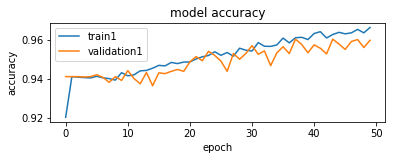

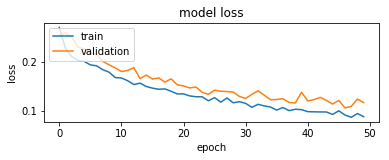

In [16]:
import matplotlib.pyplot as plt 
plt.figure(1)  
      
plt.subplot(211)  
plt.plot(history_cnn_val.history['acc'])  
plt.plot(history_cnn_val.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train1', 'validation1'], loc='upper left')  

plt.figure()   
   
plt.subplot(212)  
plt.plot(history_cnn_val.history['loss'])  
plt.plot(history_cnn_val.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'validation'], loc='upper left')  
plt.show()

**Loading the weights of trained model and start training again.**

Retraining from saved model

In [0]:
model_cnn_modify=tf.keras.models.load_model('/content/gdrive/My Drive/testx/Models_customized/customized_weights.50-0.11.hdf5')

In [0]:
model_cnn_modify.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=1e-4), metrics=['acc'])

 Train the model

In [29]:
history_cnn_val = model_cnn_modify.fit_generator(
      train_generator_cnn,
      steps_per_epoch=22,  
      epochs=50,
      validation_data=validation_generator_cnn,
      validation_steps=11, 
      callbacks = [checkpoint],
      verbose=1)

Epoch 1/50
22/22 [==============================] - 24s 1s/step - loss: 0.0949 - acc: 0.9647 - val_loss: 0.0954 - val_acc: 0.9615
Epoch 2/50
22/22 [==============================] - 19s 843ms/step - loss: 0.0811 - acc: 0.9687 - val_loss: 0.1035 - val_acc: 0.9596
Epoch 3/50
22/22 [==============================] - 18s 813ms/step - loss: 0.0802 - acc: 0.9697 - val_loss: 0.1188 - val_acc: 0.9574
Epoch 4/50
22/22 [==============================] - 15s 667ms/step - loss: 0.0804 - acc: 0.9690 - val_loss: 0.1139 - val_acc: 0.9621
Epoch 5/50
22/22 [==============================] - 22s 1s/step - loss: 0.0796 - acc: 0.9681 - val_loss: 0.1127 - val_acc: 0.9601
Epoch 6/50
22/22 [==============================] - 18s 822ms/step - loss: 0.0758 - acc: 0.9712 - val_loss: 0.1143 - val_acc: 0.9586
Epoch 7/50
22/22 [==============================] - 18s 808ms/step - loss: 0.0794 - acc: 0.9692 - val_loss: 0.1067 - val_acc: 0.9592
Epoch 8/50
22/22 [==============================] - 16s 718ms/step - loss: 

Visual the result

In [0]:
import matplotlib.pyplot as plt 
plt.figure(1)  
      
plt.subplot(211)  
plt.plot(history_cnn_val.history['acc'])  
plt.plot(history_cnn_val.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train1', 'validation1'], loc='upper left')  

plt.figure()   
   
plt.subplot(212)  
plt.plot(history_cnn_val.history['loss'])  
plt.plot(history_cnn_val.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train1', 'validation1'], loc='upper left')  
plt.show()

**Use Test Set to Evaluate Trained Model**

In [0]:
history_cnn_test = model_cnn_modify.fit_generator(      
      train_generator_cnn,
      steps_per_epoch=22,   
      epochs=50,
      validation_data=test_generator_cnn,
      validation_steps=11, 
      callbacks = [checkpoint],
      verbose=1)

**Visual the result**

In [0]:
import matplotlib.pyplot as plt 
plt.figure(1)  
      
plt.subplot(211)  
plt.plot(history_cnn_test.history['acc'])  
plt.plot(history_cnn_test.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
   
plt.figure() 

plt.subplot(212)  
plt.plot(history_cnn_test.history['loss'])  
plt.plot(history_cnn_test.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()